In [264]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import math
import warnings
warnings.simplefilter('ignore')

from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

In [265]:
@mem.cache
def get_data():
    data = load_svmlight_file("mushrooms.txt")
    return data[0], data[1]

matrix, y = get_data()
A = matrix.toarray()

Change target vector values to $\{-1, 1\}$

In [266]:
y = np.where(y==1, -1, 1)
np.unique(y, return_counts=True)

(array([-1,  1]), array([3916, 4208]))

Implement Gradient Decsent for Logistic Regression function. Rephrased problem of minimization of Logistic regression function:

$f(x) = \dfrac{1}{n} \sum_{i=1}^{n}(\log(1 + \exp(-y_{i}\cdot(Ax)_{i})) + \dfrac{\mu}{2} \| x \|_{2}^{2})$

In [267]:
def f(x, mu):
    Ax = np.matmul(A, x)
    f = len(y)**(-1) * np.sum(np.log(1 + np.exp(-y * Ax)) + mu / 2 * x @ x)
    return f

Analitically find the gradient of $f(x)$ : <br>

$\nabla f(x) = \bigg( \dfrac{1}{n} \sum_{i=1}^{n}
\big(\dfrac{\exp(-y_{i}\cdot(Ax)_{i}) \cdot A_{ij} \cdot (-y_{i})} {(1 + \exp(-y_{i}\cdot(Ax)_{i})} + \mu x_j \big) \bigg)_{j}$

In [268]:
def gradient_f(x, mu):
    Ax = np.matmul(A, x)
    exp = np.exp(-y * Ax)
    return (np.sum((exp / (1 + exp))[:, np.newaxis] * -y[:, np.newaxis] * A, axis=0) \
            + mu * x) / len(y)

Define function building plot showing $f(x)$ and $\| \nabla f(x)\|_2$ dependence on Epochs.

In [384]:
def create_plot(x_values, mu, algorithm, epochs_num=[]):
    if epochs_num != []:
        abscissa = epochs_num
    else:
        abscissa = range(1, len(x_values)+1)
        
    plt.figure(figsize=(15, 5))
    plt.xlabel("$Epochs$")
    plt.title("Values of the function and the gradient in " + \
              algorithm)
    plt.scatter(abscissa, vector_f(x_values, mu), alpha=0.2, s=50, \
                label="$f(x)$")
    plt.scatter(abscissa, vector_gradient_f(x_values, mu), alpha=0.2, s=50, \
                color = 'r', label=r'$\|\| \nabla f(x) \|\|_2$')
    plt.legend(loc='best')

def vector_f(x, mu):
    Ax = np.matmul(A, np.transpose(x))
    exp = np.exp((-y)[:, np.newaxis] * Ax)
    return np.sum(np.log(1 + exp), axis=0) / len(y) + \
        np.diagonal((mu / 2 * (x @ np.transpose(x))))

def vector_gradient_f(x, mu):
    Ax = np.matmul(A, np.transpose(x))
    exp = np.exp((-y)[:, np.newaxis] * Ax)
    sumup = ((np.transpose(exp / (1 + exp)) @ (-y[:, np.newaxis] * A)) + mu * x) \
        / len(y)
    return np.sqrt(np.diagonal(sumup @ np.transpose(sumup)))


#### Implement the gradient descent algorithm with different types of steps:
1. Constant step <br> $\alpha_{k} = \alpha$
2. Armijo rule step <br> If following is true for $\alpha:$ <br>
$ f(x_{k} + \alpha h_{k}) - f(x_{k}) ≤\varepsilon \alpha \langle \nabla f(x_k), h_{k} \rangle$, where $h_k = -\nabla f(x_k); 0 < \theta, \varepsilon < 1$ <br>
Otherwise try new $\alpha = \theta * \alpha$

In [280]:
delta, theta = np.random.rand(2)

In [281]:
def step_const_rule(alpha, x, mu):
    return alpha
    
def armijo_rule(x_k, mu, alpha, eps):
    grad_f = gradient_f(x_k, mu)
    if f(x_k + np.multiply(-alpha, grad_f), mu) - f(x_k, mu) <= \
            eps * alpha * np.matmul(np.transpose(grad_f), np.multiply(-1, grad_f)):
        return True
    else:
        return False
    
def step_armijo_rule(alpha, x_k, mu):
    while armijo_rule(x_k, mu, alpha, delta) == False:
        alpha = delta*alpha
    return alpha

Introduce the shutdown criterion based on the rate of correctly predicted answers.

In [282]:
def criterion_answers_rate(x, rate):
    return np.sum(np.where((A @ x) > 0, 1, -1) == y) > rate * len(y)

**Gradient descend function:** <br>
Repeat until the criterion is true or iterations limit reached <br>$ x_{k+1} = x_{k} - \alpha_{k} \cdot \nabla f(x_{k})$

In [402]:
def gradient_descent(f, step_rule, criterion, rate, alpha, mu, x_k):
    max_iter, iter_num = 5000, 0
    vector_x = []
    
    while (criterion(x_k, rate) == False and iter_num < max_iter): 
        alpha = step_rule(alpha, x_k, mu)
        x_k = x_k - alpha * gradient_f(x_k, mu)
        iter_num += 1
        vector_x.append(x_k)
        
    return np.array(vector_x)

Setup starting data with step $= 0.01$ and confidence rate 0,95.

In [403]:
alpha = 10**(-2)
N = 10**4
x_0 = np.ones_like(A[1])
mu = lambda N: np.max((A @ np.transpose(A)).diagonal()) / (4 * (N - 1))
L = lambda N: N / (4*(N - 1)) * np.max((A @ np.transpose(A)).diagonal())
rate = 0.97

Launch GD with different step choice rule and compare results. 

In [404]:
gd_const_x_vals = gradient_descent(f, step_const_rule, criterion_answers_rate, rate, \
                            alpha, mu(N), x_0)

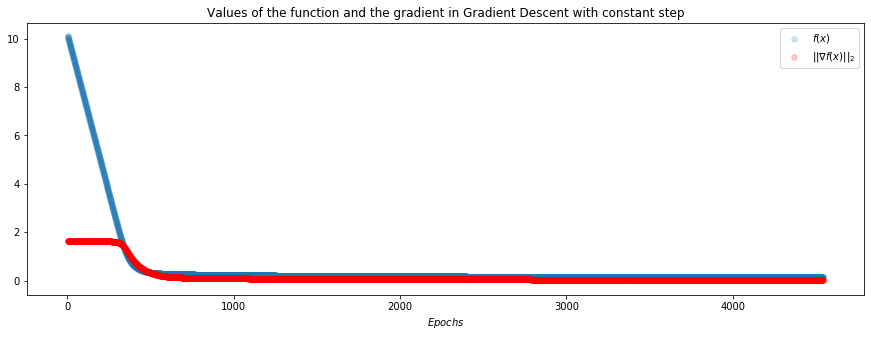

In [341]:
create_plot(gd_const_x_vals, mu(N), "Gradient Descent with constant step")

In [313]:
gd_armijo_x_vals = gradient_descent(f, step_armijo_rule, criterion_answers_rate, rate, \
                             alpha, mu(N), x_0)

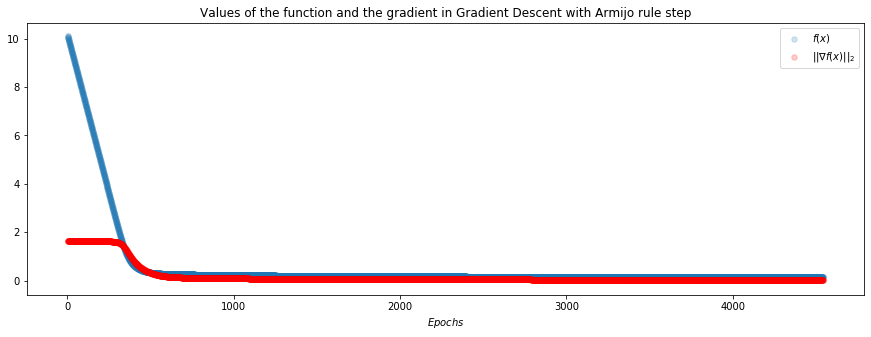

In [342]:
create_plot(gd_armijo_x_vals, mu(N), "Gradient Descent with Armijo rule step") 

Try this method on $N = 1000 => \mu = L/1000$

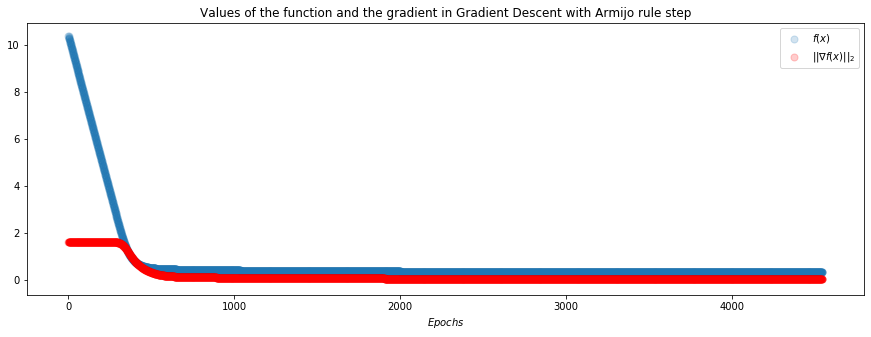

In [398]:
N = 1000
gd_armijo_x_vals = gradient_descent(f, step_armijo_rule, criterion_answers_rate, rate, \
                             alpha, mu(N), x_0)
create_plot(gd_armijo_x_vals, mu(N), "Gradient Descent with Armijo rule step") 

**Implement stochastic GD.**

We find $\nabla f_i(x)$, where $f_i$ - randomly choosen func from <br>
$f(x) = \dfrac{1}{n} \sum_{i=1}^{n} f_i(x)$

In [52]:
def gradient_f_i(x, mu, i):
    Ax = A @ x
    exp = np.exp(-y[i] * Ax[i])
    return (-(exp / (1 + exp)) * A[i]) * y[i] + mu * x

In [315]:
def stoch_gd(f, step_rule, criteria, rate, alpha, mu, x_k):
    max_iter, iter_num = 100000, 0
    vector_x = []
    
    while criteria(x_k, rate) == False and iter_num < max_iter: 
        alpha = step_rule(alpha, x_k, mu)
        i = np.random.randint(len(y))
        x_k = x_k - alpha * gradient_f_i(x_k, mu, i)
        iter_num += 1
        vector_x.append(x_k)
        
    return np.array(vector_x)

In [ ]:
N = 10000
sgd_x_vals = stoch_gd(f, step_const_rule, criterion_answers_rate, rate, 
              alpha, mu(N), x_0)

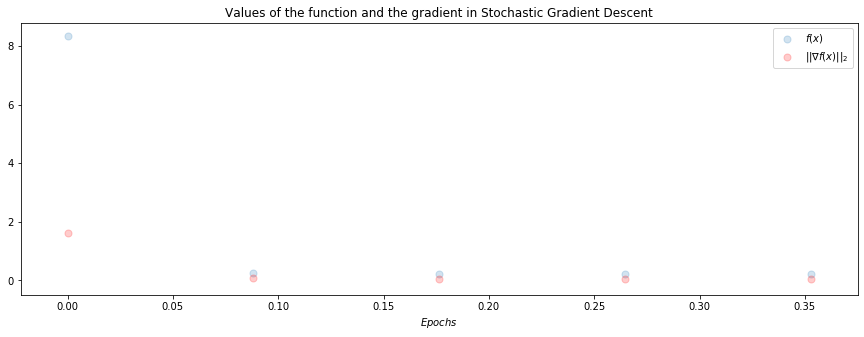

In [385]:
create_plot(sgd_x_vals[:len(sgd_x_vals):int(len(sgd_x_vals)/4)] + sgd_x_vals[-1], mu(N), \
            "Stochastic Gradient Descent", \
            epochs_num=np.arange(0, len(sgd_x_vals)/len(y), (len(sgd_x_vals)/len(y))/5))

Try this method on $N = 2 => \mu = L/2$

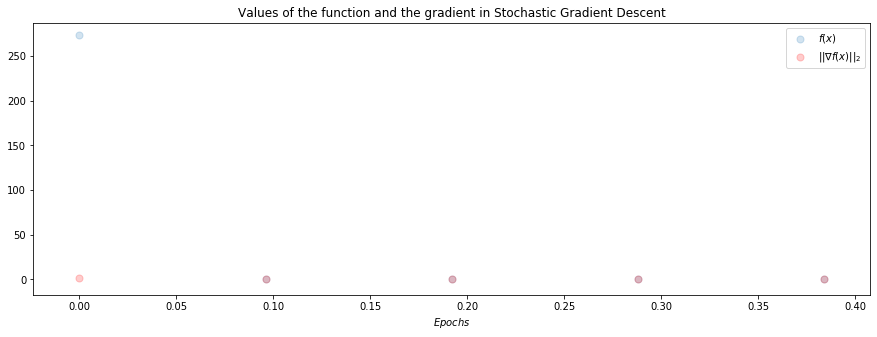

In [390]:
N = 2
sgd_x_vals = stoch_gd(f, step_const_rule, criterion_answers_rate, rate, 
              alpha, mu(N), x_0)
create_plot(sgd_x_vals[:len(sgd_x_vals):int(len(sgd_x_vals)/4)] + sgd_x_vals[-1], mu(N), \
            "Stochastic Gradient Descent", \
            epochs_num=np.arange(0, len(sgd_x_vals)/len(y), (len(sgd_x_vals)/len(y))/5))

**Implement Nesterov Accelerated Gradient:**

In [408]:
def nesterov_gd(f, criteria, rate, mu, L, x_k, y_k):
    max_iter, iter_num = 700, 0
    x_next = y_k - 1/L * gradient_f(x_k, mu)
    y_next = x_next + (math.sqrt(L) - math.sqrt(mu)) / (math.sqrt(L) + math.sqrt(mu)) * \
        (x_next - x_k)
    vector_x = []
    
    while (criteria(x_k, rate) == False and (iter_num < max_iter)): 
        x_next = y_k - 1/L * gradient_f(x_k, mu)
        y_next = x_next + (math.sqrt(L) - math.sqrt(mu)) / (math.sqrt(L) + math.sqrt(mu)) * \
            (x_next - x_k)
        x_k, y_k = x_next, y_next
        iter_num += 1
        vector_x.append(x_k)
        
    return np.array(vector_x)

In [388]:
N = 10000
nesterov_acc_gd_x_vals = nesterov_gd(f, criterion_answers_rate, rate, mu(N), L(N), x_0, x_0)

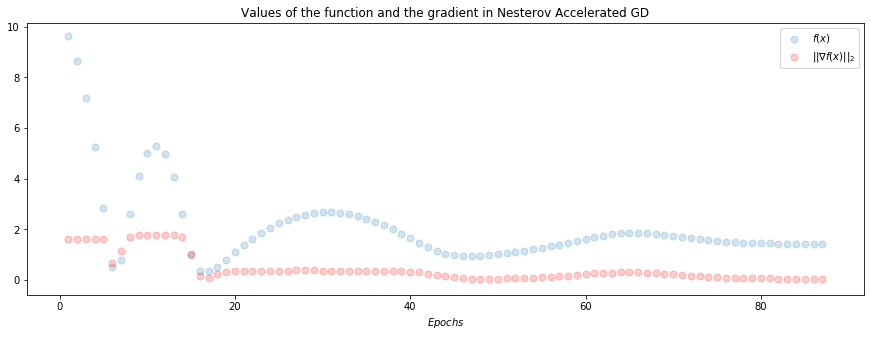

In [389]:
create_plot(nesterov_acc_gd, mu(N), "Nesterov Accelerated GD")

Try this method on $N = 1000 => \mu = L/1000$

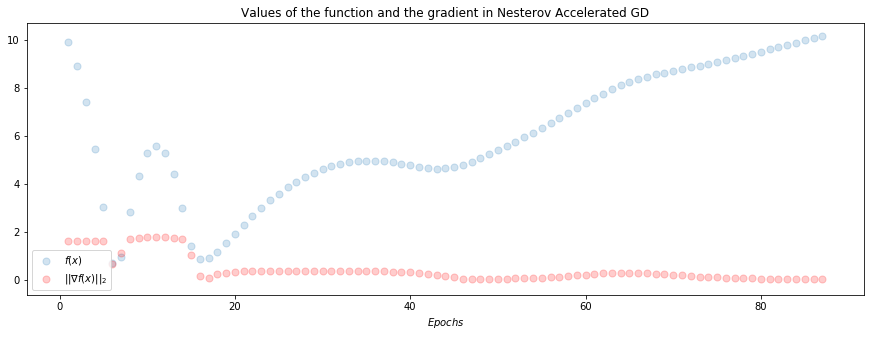

In [411]:
N = 1000
nesterov_acc_gd_x_vals = nesterov_gd(f, criterion_answers_rate, rate, mu(N), L(N), x_0, x_0)
create_plot(nesterov_acc_gd, mu(N), "Nesterov Accelerated GD")

**To conclude with**, we can see that Gradient Descent (both with constant rule step and  Armijo rule step), Stochastic GD and Nesterov Accelerated GD provide us with good minimization of function, but Stochastic GD is the fastest one regardless of the choice of condition number $\mu$. 